In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [2]:

# EDA
data = pd.read_csv('Food_Inspections.csv')
# print(data.shape)
# print(data.dtypes)

# Results - separating the Fail and Pass
data['Results'].unique()
# dropping the results that do not contain pass or fail
data = data.drop(data[~((data['Results'] == 'Pass') | (data['Results'] == 'Fail'))].index)
# print(data['Results'].unique())

data = pd.concat([data, pd.get_dummies(data['Results'])], axis=1)
data = data.drop(['Results', 'Pass'], axis=1)

In [3]:
data.shape

(182267, 17)

In [6]:
data['Inspection Type'].unique()

array(['Canvass', 'License', 'Canvass Re-Inspection',
       'License Re-Inspection', 'Short Form Complaint',
       'Complaint Re-Inspection', 'Complaint', 'Recent Inspection',
       'Suspected Food Poisoning',
       'Suspected Food Poisoning Re-inspection', 'Consultation',
       'Task Force Liquor 1475', 'Complaint-Fire', 'NO ENTRY',
       'License-Task Force', 'Tag Removal', 'Out of Business', 'No Entry',
       'out ofbusiness', 'OUT OF BUSINESS', 'Non-Inspection',
       'Special Events (Festivals)', 'Recent inspection', nan,
       'Complaint-Fire Re-inspection', 'Short Form Fire-Complaint',
       'OWNER SUSPENDED OPERATION/LICENSE', 'LICENSE CONSULTATION',
       'Illegal Operation', 'License consultation', 'fire complaint',
       'Not Ready', 'Package Liquor 1474', 'No entry',
       'CANVASS SPECIAL EVENTS', 'TWO PEOPLE ATE AND GOT SICK.',
       'CANVASS SCHOOL/SPECIAL EVENT', 'Pre-License Consultation',
       'no entry', 'FIRE/COMPLAIN', '1315 license reinspection',
 

In [9]:
data['Inspection Type'].fillna('', inplace=True)
filtered_data = data[~data['Inspection Type'].str.contains('Re-Inspection', case=False)]

# feature analysis

In [8]:
def feature_analysis(data):
    # VIOLATION FEATURE ANALYSIS
    data['Violation_NA_Count'] = data.groupby('License #')['Violations'].apply(lambda x: x.isna().sum())
    data['Violation_NA_Count'].fillna(0, inplace=True)
    data['Violation_NA_Percentage'] = (data['Violation_NA_Count'] / data.groupby('License #').size()) * 100
    # dropping the rows with violations missing values
    data.drop(data[data['Violation_NA_Percentage'] > 0].index, axis=0, inplace=True)
    data.drop(['Violation_NA_Count', 'Violation_NA_Percentage'], axis=1, inplace=True)
    # Calculate the count of violations per License #
    data['violations_count_per_license'] = data.groupby('License #')['Violations'].transform('count')
    # Calculate the average count of violations per establishment
    data['average_violations_per_establishment'] = data['violations_count_per_license'] / data.groupby('License #')[
        'License #'].transform('count') * 100
    data['fail_rate_per_establishment'] = data.groupby('License #')['Fail'].transform('sum') / \
                                          data.groupby('License #')['License #'].transform('count') * 100

    # Scatter plot_ by violation count
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x='violations_count_per_license', y='fail_rate_per_establishment', data=data)

    plt.title('Scatter Plot of violations_count_per_license & fail rate')
    plt.xlabel('violations_count_per_license')
    plt.ylabel('fail_rate_per_establishment')
    plt.show()

    # Scatter plot - by violation weight
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x='average_violations_per_establishment', y='fail_rate_per_establishment', data=data)

    plt.title('Scatter Plot of Average Violations per Establishment vs. fail_rate_per_establishment')
    plt.xlabel('Average Violations per Establishment')
    plt.ylabel('fail_rate_per_establishment')
    plt.show()


    # Dropping Outlier with high violation
    data.drop(data[data['violations_count_per_license'] > 50].index, inplace=True)
    # Scatter plot
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x='violations_count_per_license', y='fail_rate_per_establishment', data=data)

    plt.title('Scatter Plot of violations_count_per_license & fail rate')
    plt.xlabel('violations_count_per_license')
    plt.ylabel('fail_rate_per_establishment')
    plt.show()

    # INSPECTION TYPE FEATURE ANALYSIS

    # dropping the 1 na row with missing inspection type
    # data['Inspection Type'].isna().sum()
    data = data.drop(data[data['Inspection Type'].isna()].index)
    # selecting the data that contain the specified inspection types
    data['Inspection_Canvass'] = data['Inspection Type'].str.contains('Canvass', case=False, na=False)
    data['Inspection_Suspect'] = data['Inspection Type'].str.contains('Suspect', case=False, na=False)
    data['Inspection_Task'] = data['Inspection Type'].str.contains('Task', case=False, na=False)
    data['Inspection_Consultation'] = data['Inspection Type'].str.contains('Consultation', case=False, na=False)
    data['Inspection_Complaint'] = data['Inspection Type'].str.contains('Complaint', case=False, na=False)
    data['Inspection_License'] = data['Inspection Type'].str.contains('License', case=False, na=False)
    data['Inspection_other'] = ~data['Inspection Type'].str.contains(
        'Canvass|Suspect|Task|Consultation|Complaint|License', case=False, na=False)

    # fail rate analysis by inspection types
    fail_rate_per_canvas = data.groupby('Inspection_Canvass')['Fail'].sum() / data.groupby('Inspection_Canvass')[
        'Inspection_Canvass'].sum() * 100
    fail_rate_per_suspect = data.groupby('Inspection_Suspect')['Fail'].sum() / data.groupby('Inspection_Suspect')[
        'Inspection_Suspect'].sum() * 100
    fail_rate_per_Task = data.groupby('Inspection_Task')['Fail'].sum() / data.groupby('Inspection_Task')[
        'Inspection_Task'].sum() * 100
    fail_rate_per_Consultation = data.groupby('Inspection_Consultation')['Fail'].sum() / \
                                 data.groupby('Inspection_Consultation')['Inspection_Consultation'].sum() * 100
    fail_rate_per_complaint = data.groupby('Inspection_Complaint')['Fail'].sum() / data.groupby('Inspection_Complaint')[
        'Inspection_Complaint'].sum() * 100
    fail_rate_per_license = data.groupby('Inspection_License')['Fail'].sum() / data.groupby('Inspection_License')[
        'Inspection_License'].sum() * 100
    fail_rate_per_other = data.groupby('Inspection_other')['Fail'].sum() / data.groupby('Inspection_other')[
        'Inspection_other'].sum() * 100

    print(fail_rate_per_canvas, fail_rate_per_suspect, fail_rate_per_Task, fail_rate_per_Consultation,
          fail_rate_per_complaint, fail_rate_per_license, fail_rate_per_other)

    # RISK FEATURE ANALYSIS
    fail_percentage_by_risk = (data.groupby('Risk')['Fail'].sum() / data.groupby('Risk').size()) * 100

    Failure_by_risk = pd.DataFrame({'Risk': fail_percentage_by_risk.index, 'Failure': fail_percentage_by_risk})

    plt.figure(figsize=(20, 6))
    sns.barplot(x='Risk', y='Failure', data=Failure_by_risk)

    plt.title('Fail Percentage by Risk')
    plt.xlabel('Risk')
    plt.ylabel('Fail Percentage')
    plt.xticks(rotation=90)
    plt.show()

    # TYPEOF FACILITY FEATURE
    Facility_counts = data['Facility Type'].value_counts().sort_values(ascending=False)
    fail_percentage_by_facility = data.groupby('Facility Type')['Fail'].sum() / data.groupby(
        'Facility Type').size() * 100
    Failure_by_facility = pd.DataFrame(
        {'Facility Type': fail_percentage_by_facility.index, 'Failure': fail_percentage_by_facility.values,
         'Num_Inspections': Facility_counts.values})
    Failure_by_facility = Failure_by_facility.sort_values(by='Facility Type')

    # Set up the figure and the first y-axis (fail percentage)
    fig, ax1 = plt.subplots(figsize=(15, 6))
    ax1 = sns.barplot(x='Facility Type', y='Failure', data=Failure_by_facility, ax=ax1, color='steelblue')
    ax1.set_ylabel('Fail Percentage', color='steelblue')
    ax1.tick_params(axis='y', labelcolor='steelblue')

    # Create the second y-axis (number of inspections) and plot the bar graph
    ax2 = ax1.twinx()
    ax2 = sns.barplot(x='Facility Type', y='Num_Inspections', data=Failure_by_facility, ax=ax2, color='lightcoral')
    ax2.set_ylabel('Number of Inspections', color='lightcoral')
    ax2.tick_params(axis='y', labelcolor='lightcoral')

    plt.title('Fail Percentage and Number of Inspections by Facility')
    plt.xlabel('Facility')
    plt.xticks(rotation=90)
    plt.show()

    facility_fail_count = data.groupby('Facility Type')['Fail'].sum().reset_index()
    facility_fail_count = facility_fail_count[facility_fail_count['Fail'] > 10].sort_values(by='Fail', ascending=False)
    print(facility_fail_count)

    facility_weight = Facility_counts / len(data['Facility Type']) * 100
    facility_weight.sort_values(ascending=False)
    print(facility_weight)

    # DUMMIES

    # Risk dummies
    data = pd.concat([data, pd.get_dummies(data['Risk'], prefix='Risk', prefix_sep='_')], axis=1)
    # Filter facility types where the weight is greater than 5%
    selected_facility_types = facility_weight[facility_weight > 5].index
    # Create dummy variables only for the selected facility types
    dummy_columns = [f'Facility Type_{facility_type}' for facility_type in selected_facility_types]
    data = pd.concat(
        [data, pd.get_dummies(data['Facility Type'], prefix='Facility Type', prefix_sep='_')[dummy_columns]], axis=1)
    # Filter facility types where the weight is lower than 5%
    other_facility_types = facility_weight[facility_weight <= 5].index
    # Create a new column 'Facility Type_other' with 1 if it's another facility type, 0 otherwise
    data['Facility Type_other'] = data['Facility Type'].apply(lambda x: 1 if x in other_facility_types else 0)
    # Drop the original 'Facility Type' column
    data.drop(columns='Facility Type', inplace=True)

    # Drop rows with missing license numbers
    data.dropna(subset=['License #'], inplace=True)


    # columns_to_drop = ['DBA Name', 'AKA Name', 'Address', 'City', 'State', 'Latitude', 'Longitude', 'Location']
    columns_to_drop = ['DBA Name', 'AKA Name', 'Address', 'City', 'State', 'Latitude', 'Longitude', 'Location',
                       'Inspection Type', 'Risk', 'Zip', 'Violations',  'Inspection ID', 'License #',
                       'Inspection Date', 'violations_count_per_license', 'fail_rate_per_establishment']
    data.drop(columns_to_drop, axis=1, inplace=True)
    
    return data

# Model

In [ ]:
def model(data):
    # Split the Data
    from sklearn.model_selection import train_test_split
    

    # Split the data into features (X) and target (y)
    X = data.drop(columns=['Fail'])
    y = data['Fail']

    # Split the data into training, validation, and testing sets
    X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

    # Step 3: Choose Candidate Models
    from sklearn.linear_model import LogisticRegression
    from sklearn.tree import DecisionTreeClassifier
    from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

    # Initialize candidate models
    logistic_regression = LogisticRegression(solver='lbfgs', penalty='l2', max_iter=1000, random_state=42)
    decision_tree = DecisionTreeClassifier(random_state=42)
    random_forest = RandomForestClassifier(random_state=42)
    gradient_boosting = GradientBoostingClassifier(random_state=42)

    # Step 4: Train and Tune Models
    from sklearn.model_selection import GridSearchCV

    # Define hyperparameter grids for tuning
    param_grid_logreg = {
        'C': [0.1, 1, 10],
        'penalty': ['l1', 'l2'],
    }

    param_grid_dt = {
        'max_depth': [None, 10, 20],
        'min_samples_split': [2, 5, 10],
    }

    param_grid_rf = {
        'n_estimators': [50, 100, 200],
        'max_depth': [None, 10, 20],
    }

    param_grid_gb = {
        'n_estimators': [50, 100, 200],
        'learning_rate': [0.1, 0.01, 0.001],
    }

    # Perform GridSearchCV for each model to find the best hyperparameters
    grid_search_logreg = GridSearchCV(logistic_regression, param_grid_logreg, cv=5)
    grid_search_dt = GridSearchCV(decision_tree, param_grid_dt, cv=5)
    grid_search_rf = GridSearchCV(random_forest, param_grid_rf, cv=5)
    grid_search_gb = GridSearchCV(gradient_boosting, param_grid_gb, cv=5)

    # Fit the models with the training data
    grid_search_logreg.fit(X_train, y_train)
    grid_search_dt.fit(X_train, y_train)
    grid_search_rf.fit(X_train, y_train)
    grid_search_gb.fit(X_train, y_train)

    # Step 5: Evaluate Models
    from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve
  
    # Define a function to evaluate the models
    def evaluate_model(model, X, y):
        y_pred = model.predict(X)
        accuracy = accuracy_score(y, y_pred)
        precision = precision_score(y, y_pred)
        recall = recall_score(y, y_pred)
        f1 = f1_score(y, y_pred)
        y_prob = model.predict_proba(X)[:, 1]
        fpr, tpr, thresholds = roc_curve(y, y_prob)
        auc_score = roc_auc_score(y, y_prob)

        plt.plot(fpr, tpr, label=f'{model} (AUC = {auc_score:.2f})')
        plt.plot([0, 1], [0, 1], 'k--')  # Diagonal line (random model)
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curve')
        plt.legend(loc='lower right')
        plt.grid(True)
        
        return accuracy, precision, recall, f1, roc_auc

    # Evaluate the models on the training set
    logreg_accuracy_train, logreg_precision_train, logreg_recall_train, logreg_f1_train, logreg_roc_auc_train = evaluate_model(
        grid_search_logreg, X_train, y_train)
    dt_accuracy_train, dt_precision_train, dt_recall_train, dt_f1_train, dt_roc_auc_train = evaluate_model(
        grid_search_dt, X_train, y_train)
    rf_accuracy_train, rf_precision_train, rf_recall_train, rf_f1_train, rf_roc_auc_train = evaluate_model(
        grid_search_rf, X_train, y_train)
    gb_accuracy_train, gb_precision_train, gb_recall_train, gb_f1_train, gb_roc_auc_train = evaluate_model(
        grid_search_gb, X_train, y_train)

    # Evaluate the models on the validation set
    logreg_accuracy_val, logreg_precision_val, logreg_recall_val, logreg_f1_val, logreg_roc_auc_val = evaluate_model(
        grid_search_logreg, X_val, y_val)
    dt_accuracy_val, dt_precision_val, dt_recall_val, dt_f1_val, dt_roc_auc_val = evaluate_model(grid_search_dt, X_val,
                                                                                                 y_val)
    rf_accuracy_val, rf_precision_val, rf_recall_val, rf_f1_val, rf_roc_auc_val = evaluate_model(grid_search_rf, X_val,
                                                                                                 y_val)
    gb_accuracy_val, gb_precision_val, gb_recall_val, gb_f1_val, gb_roc_auc_val = evaluate_model(grid_search_gb, X_val,
                                                                                                 y_val)

    # Evaluate the models on the testing set
    logreg_accuracy_test, logreg_precision_test, logreg_recall_test, logreg_f1_test, logreg_roc_auc_test = evaluate_model(
        grid_search_logreg, X_test, y_test)
    dt_accuracy_test, dt_precision_test, dt_recall_test, dt_f1_test, dt_roc_auc_test = evaluate_model(grid_search_dt,
                                                                                                      X_test, y_test)
    rf_accuracy_test, rf_precision_test, rf_recall_test, rf_f1_test, rf_roc_auc_test = evaluate_model(grid_search_rf,
                                                                                                      X_test, y_test)
    gb_accuracy_test, gb_precision_test, gb_recall_test, gb_f1_test, gb_roc_auc_test = evaluate_model(grid_search_gb,
                                                                                                      X_test, y_test)

    # Print the evaluation metrics for train model
    print("Logistic Regression - Training sample:")
    print(
        f"Accuracy: {logreg_accuracy_train}, Precision: {logreg_precision_train}, Recall: {logreg_recall_train}, F1: {logreg_f1_train}, ROC-AUC: {logreg_roc_auc_train}")

    print("Decision Tree - Training sample:")
    print(
        f"Accuracy: {dt_accuracy_train}, Precision: {dt_precision_train}, Recall: {dt_recall_train}, F1: {dt_f1_train}, ROC-AUC: {dt_roc_auc_train}")

    print("Random Forest - Training sample:")
    print(
        f"Accuracy - Training sample: {rf_accuracy_train}, Precision: {rf_precision_train}, Recall: {rf_recall_train}, F1: {rf_f1_train}, ROC-AUC: {rf_roc_auc_train}")

    print("Gradient Boosting - Training sample:")
    print(
        f"Accuracy: {gb_accuracy_train}, Precision: {gb_precision_train}, Recall: {gb_recall_train}, F1: {gb_f1_train}, ROC-AUC: {gb_roc_auc_train}")

    # Print the evaluation metrics for validation model
    print("Logistic Regression - Validation sample:")
    print(
        f"Accuracy: {logreg_accuracy_val}, Precision: {logreg_precision_val}, Recall: {logreg_recall_val}, F1: {logreg_f1_val}, ROC-AUC: {logreg_roc_auc_val}")

    print("Decision Tree - Validation sample:")
    print(
        f"Accuracy: {dt_accuracy_val}, Precision: {dt_precision_val}, Recall: {dt_recall_val}, F1: {dt_f1_val}, ROC-AUC: {dt_roc_auc_val}")

    print("Random Forest - Validation sample:")
    print(
        f"Accuracy - Val sample: {rf_accuracy_val}, Precision: {rf_precision_val}, Recall: {rf_recall_val}, F1: {rf_f1_val}, ROC-AUC: {rf_roc_auc_val}")

    print("Gradient Boosting - Validation sample:")
    print(
        f"Accuracy: {gb_accuracy_val}, Precision: {gb_precision_val}, Recall: {gb_recall_val}, F1: {gb_f1_val}, ROC-AUC: {gb_roc_auc_val}, ROC-AUC: {gb_roc_auc_val}")

    # Print the evaluation metrics for testing sample
    print("Logistic Regression - Testing sample:")
    print(
        f"Accuracy: {logreg_accuracy_test}, Precision: {logreg_precision_test}, Recall: {logreg_recall_test}, F1: {logreg_f1_test}, ROC-AUC: {logreg_roc_auc_test}")

    print("Decision Tree - Testing sample:")
    print(
        f"Accuracy: {dt_accuracy_test}, Precision: {dt_precision_test}, Recall: {dt_recall_test}, F1: {dt_f1_test}, ROC-AUC: {dt_roc_auc_test}")

    print("Random Forest - Testing sample:")
    print(
        f"Accuracy - Testing sample: {rf_accuracy_test}, Precision: {rf_precision_test}, Recall: {rf_recall_test}, F1: {rf_f1_test}, ROC-AUC: {rf_roc_auc_test}")

    print("Gradient Boosting - Testing sample:")
    print(
        f"Accuracy: {gb_accuracy_test}, Precision: {gb_precision_test}, Recall: {gb_recall_test}, F1: {gb_f1_test}, ROC-AUC: {gb_roc_auc_test}")

    # Print the best parameters for each model
    print("Logistic Regression - Best Parameters:")
    print(grid_search_logreg.best_params_)

    print("Decision Tree - Best Parameters:")
    print(grid_search_dt.best_params_)

    print("Random Forest - Best Parameters:")
    print(grid_search_rf.best_params_)

    print("Gradient Boosting - Best Parameters:")
    print(grid_search_gb.best_params_)


In [11]:
#call feature aaltsis function

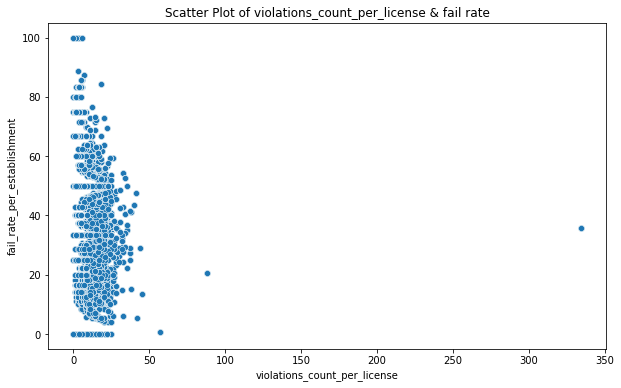

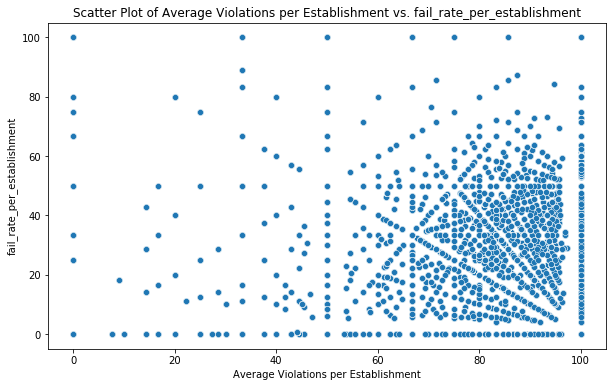

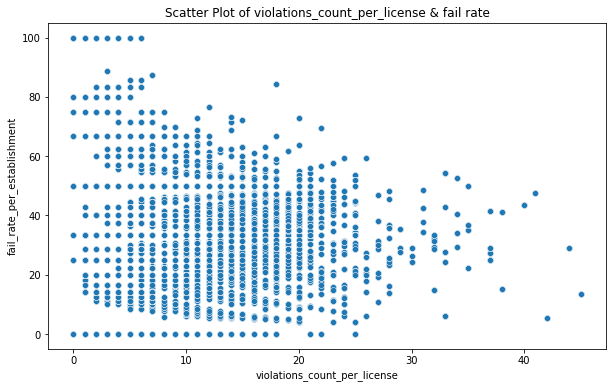

Inspection_Canvass
False          inf
True     24.217871
dtype: float64 Inspection_Suspect
False          inf
True     30.496454
dtype: float64 Inspection_Task
False          inf
True     58.057143
dtype: float64 Inspection_Consultation
False          inf
True     20.566038
dtype: float64 Inspection_Complaint
False          inf
True     30.878265
dtype: float64 Inspection_License
False          inf
True     33.263571
dtype: float64 Inspection_other
False          inf
True     24.164524
dtype: float64


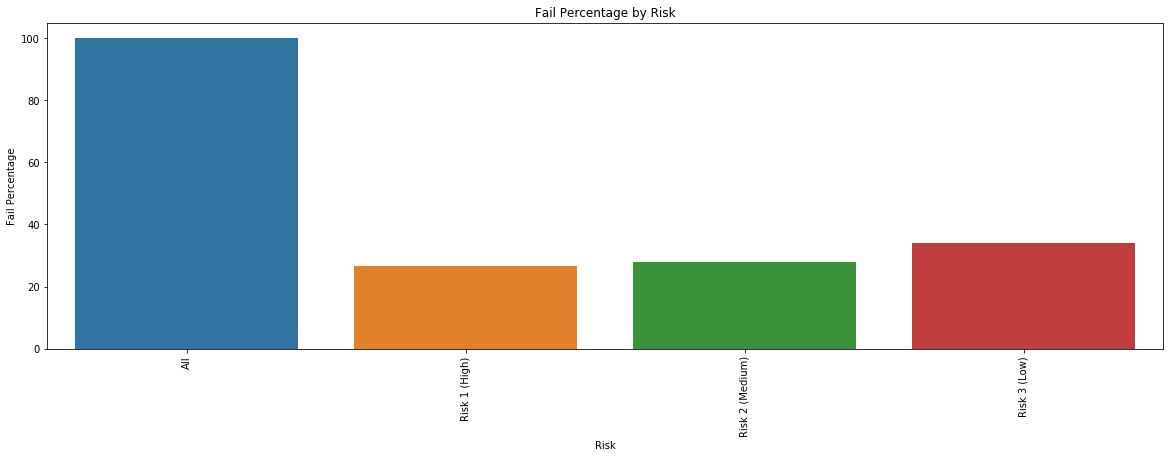

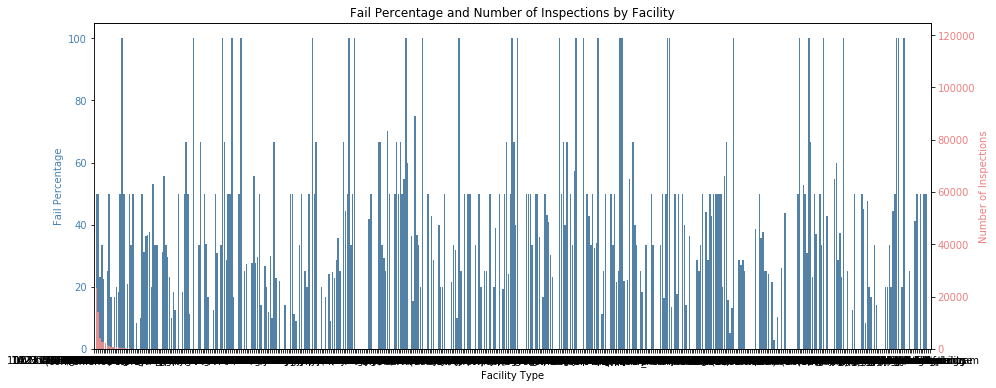

                       Facility Type     Fail
353                       Restaurant  31941.0
197                    Grocery Store   7390.0
368                           School   3403.0
101     Children's Services Facility    896.0
40                            Bakery    786.0
131  Daycare Above and Under 2 Years    630.0
128            Daycare (2 - 6 Years)    587.0
249                   Long Term Care    422.0
247                           Liquor    368.0
273            Mobile Food Dispenser    260.0
99                          Catering    243.0
274             Mobile Food Preparer    231.0
407                        Wholesale    185.0
132               Daycare Combo 1586    151.0
195                     Golden Diner    127.0
377                           TAVERN    125.0
223                         Hospital    115.0
130          Daycare (Under 2 Years)     65.0
150                      GAS STATION     55.0
29                      BANQUET HALL     37.0
370                   Shared Kitch

In [10]:
import Feature_analysis as FA
modified_data = FA.feature_analysis(data)
print(modified_data.isna().sum())


In [12]:
# call modelvaluation function

In [27]:

import train_test_validation as Model
Model.model(modified_data)

C:\Users\Yelena\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:372: FitFailedWarning: 
15 fits failed out of a total of 30.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
15 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\Yelena\Anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\Yelena\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "C:\Users\Yelena\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py", line 449, in _check_solver
    % (solver, penalty

Logistic Regression:
Accuracy: 0.7278588897947084, Precision: 0.6402439024390244, Recall: 0.014208389715832206, F1: 0.027799841143764895, ROC-AUC: 0.5055987855907188
Decision Tree:
Accuracy: 0.7292670273475135, Precision: 0.625, Recall: 0.028416779431664412, F1: 0.05436189490033653, ROC-AUC: 0.51099344789097
Random Forest:
Accuracy: 0.7293411398502927, Precision: 0.6628787878787878, Recall: 0.02368064952638701, F1: 0.045727724065847915, ROC-AUC: 0.5095694531567432
Gradient Boosting:
Accuracy: 0.728081227303046, Precision: 0.8170731707317073, Recall: 0.009066305818673884, F1: 0.017933618843683084, ROC-AUC: 0.5041504217397106
